in this notebook we:
* run first training rounds!

In [1]:
from pathlib import Path
import json
import logging

import numpy as np
import pandas as pd

from fastai.vision import *

import os

PATH_TO_TRAIN_DF = Path("/home/jupyter/inspect_data_split_validation")
PATH_TO_IMG = Path("/data/Gabon_trainingData")
PATH_TO_MODELS = Path("/home/jupyter/training/saved_models")

In [2]:
df = pd.read_csv(PATH_TO_TRAIN_DF / "train_valid_df.csv")
df.head()

,uniqueName,species,main_folder,is_valid,sub_folder
0,0000005.jpg,Human,Compressed Camera Trap Images,False,T33
1,0000007.jpg,Human,Compressed Camera Trap Images,False,T33
2,0000009.jpg,Human,Compressed Camera Trap Images,False,T33
3,0000013.jpg,Human,Compressed Camera Trap Images,False,T33
4,0000015.jpg,Human,Compressed Camera Trap Images,False,T33


In [3]:
classes = df.species.unique()
print(len(classes)) # no Blank and no "Mammal_Other"
classes

27


array(['Human', 'Elephant_African', 'Hog_Red_River', 'Buffalo_African', 'Leopard_African', 'Monkey', 'Duiker_Red',
       'Civet_African_Palm', 'Squirrel', 'Duiker_Blue', 'Bird', 'Mongoose_Black_Footed', 'Rodent',
       'Duiker_Yellow_Backed', 'Genet', 'Chimpanzee', 'Gorilla', 'Mongoose', 'Porcupine_Brush_Tailed', 'Pangolin',
       'Mandrillus', 'Chevrotain_Water', 'Cat_Golden', 'Rat_Giant', 'Guineafowl_Crested', 'Guineafowl_Black',
       'Rail_Nkulengu'], dtype=object)

In [22]:
def get_training_data(img_size, batch_size=128, partial_pct=1.0):
    np.random.seed(273)
    src = (ImageList.from_df(df, cols="uniqueName", path=PATH_TO_IMG)
           .use_partial_data(partial_pct)
           .split_from_df("is_valid")
           .label_from_df(cols="species"))

    tfms = get_transforms()  # TODO
    data = (src.transform(tfms, size=img_size, padding_mode ="zeros")
            .databunch(bs=batch_size).normalize(imagenet_stats))
    return data

def get_initial_learner(data):
#     acc_02 = partial(accuracy_thresh, thresh=0.2)
    learn = cnn_learner(data, models.resnet50, metrics=[accuracy])#, callback_fns=[partial(WandbCallback)])
    learn.model_dir = PATH_TO_MODELS
    return learn

def save_model(learn, name):
    """ This function saves the model in 'learn' to a file 'name',
    however, it saves a version stripped of callbacks (e.g., wandb) as it spoil
    inference when wandb is not available, preserving it in learn.
    """
    callbacks = learn.callback_fns  # preserve wandb callback and others
    learn.callback_fns = []  # clean callbacks

    learn.save(PATH_TO_MODELS / name)  # save only weights, adds .pth automatically
    learn.export(PATH_TO_MODELS / f"{name}.pkl")  # serialize entire model, need to add .pkl
#     wandb.save(str(PATH_TO_MODELS / f"{name}.pkl"))
    learn.callback_fns = callbacks  # restore callbacks

def load_weights(learn, name):
    if (PATH_TO_MODELS / f"{name}.pth").is_file():
        learn.load(PATH_TO_MODELS / name)
        return True
    else:
        return False

def run_training(learn, model_name, lr, n_epochs, lr_end=None):
    if load_weights(learn, model_name):
        logging.info(f"Loaded weights for {model_name}, skipping training")
    else:
        logging.info(f"running training {model_name}")

#         wandb.config[f"{model_name}_lr"] = lr
#         wandb.config[f"{model_name}_n_epochs"] = n_epochs

        lr_slice = slice(lr)
        if lr_end:
#             wandb.config[f"{model_name}_lr_end"] = lr_end
            lr_slice = slice(lr, lr_end)

        learn.fit_one_cycle(n_epochs, lr_slice)
        logging.info(f"finished training {model_name}")
        save_model(learn, model_name)
        logging.info(f"saved {model_name}")
        
def run_find_lr(learn, model_name):
    learn.lr_find()
    fig = learn.recorder.plot(return_fig=True)
    fig_name = f"lr_find_for_{model_name}"
#     wandb.log({fig_name: fig})
    fig.savefig(fig_name + ".png")

In [5]:
data = get_training_data((384 // 4, 512 // 4), partial_pct=0.01)

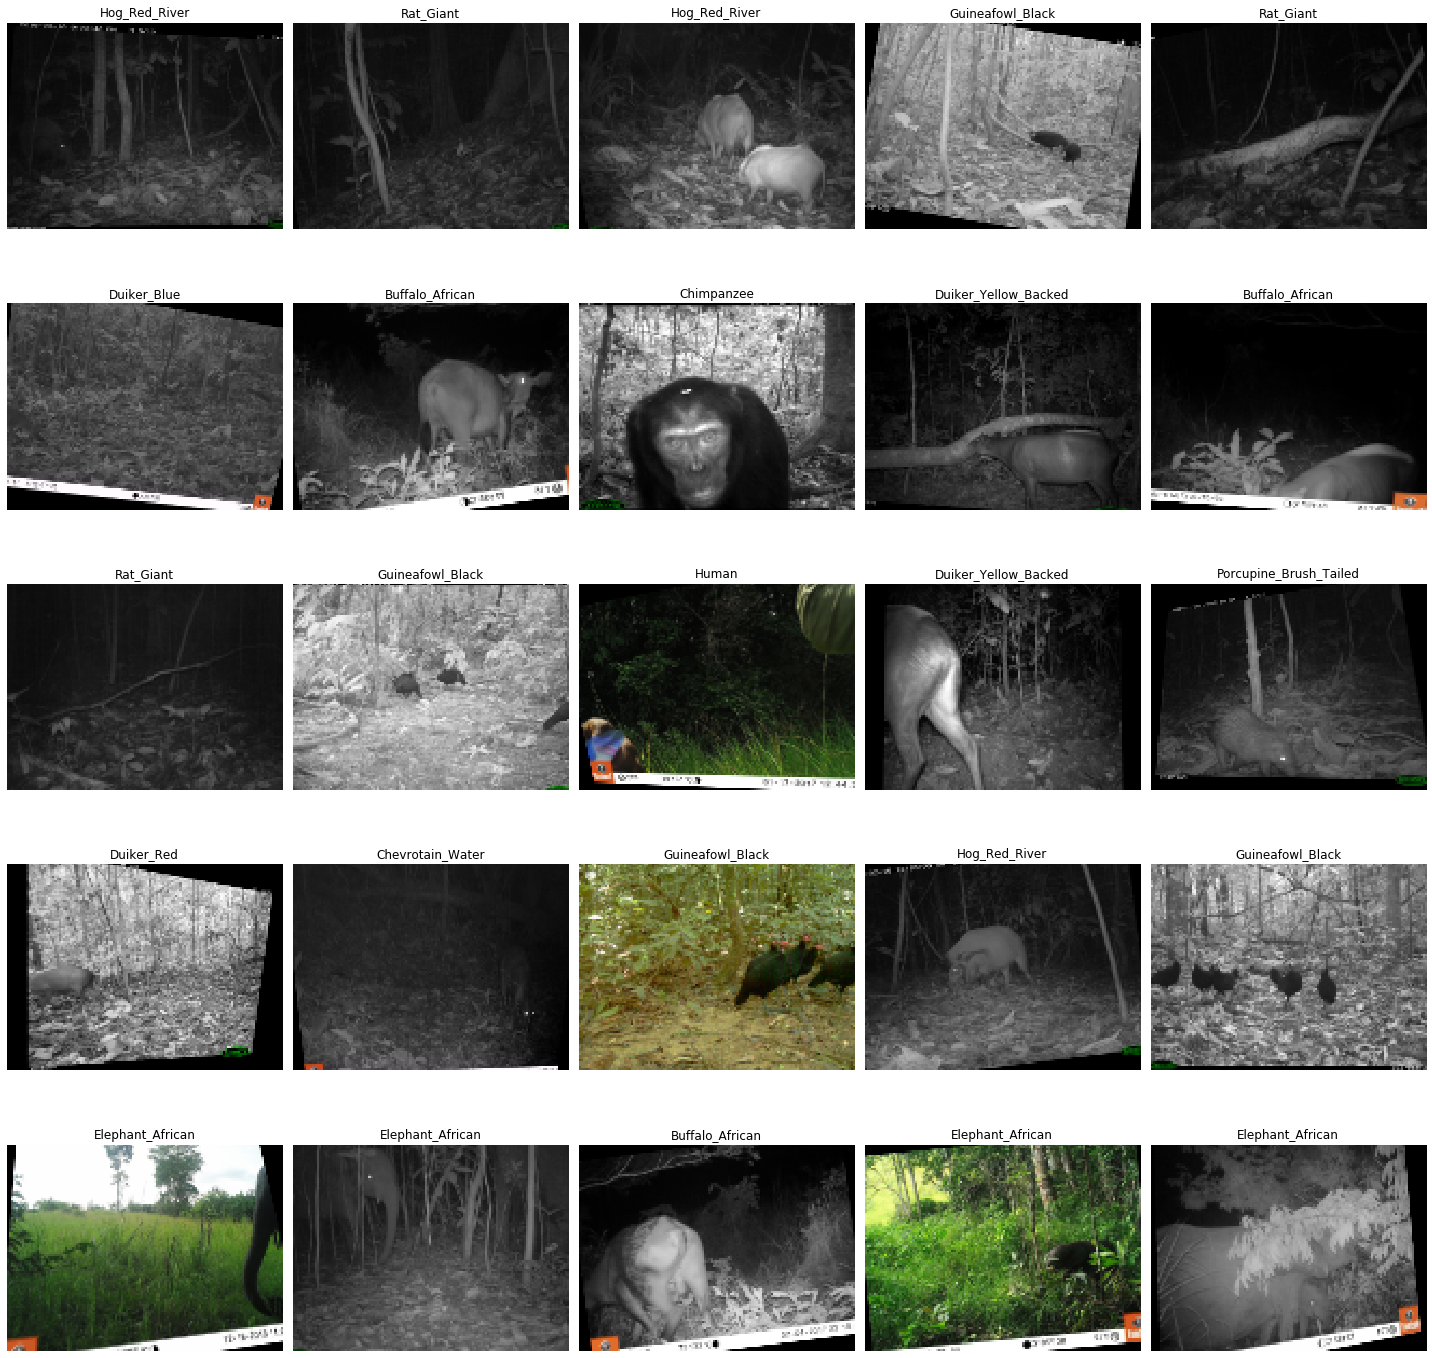

In [6]:
data.show_batch()

In [23]:
learn = get_initial_learner(data)

In [24]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
CPU times: user 7.55 s, sys: 1.73 s, total: 9.28 s
Wall time: 8min 18s


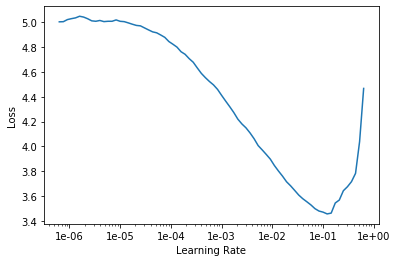

In [25]:
%%time
run_find_lr(learn, "stage1-1epochs-96_128")

In [26]:
%%time
initial_lr = 0.01
run_training(learn, "stage1-1epochs-96_128", lr=initial_lr, n_epochs=10)

epoch,train_loss,valid_loss,accuracy,time
0,3.165729,3.528133,0.278894,02:09
1,2.649289,3.204106,0.273869,02:14
2,2.333333,2.951925,0.246231,02:10
3,2.099991,2.792850,0.311558,02:09
4,1.930553,2.645498,0.331658,02:13
5,1.758571,2.467539,0.371859,02:15
6,1.619394,2.566592,0.344221,02:11
7,1.492326,2.447048,0.386935,02:11
8,1.383332,2.436187,0.386935,02:14
9,1.315635,2.443464,0.379397,02:11


CPU times: user 18.4 s, sys: 5.4 s, total: 23.8 s
Wall time: 22min 3s


In [29]:
interp = ClassificationInterpretation.from_learner(learn)

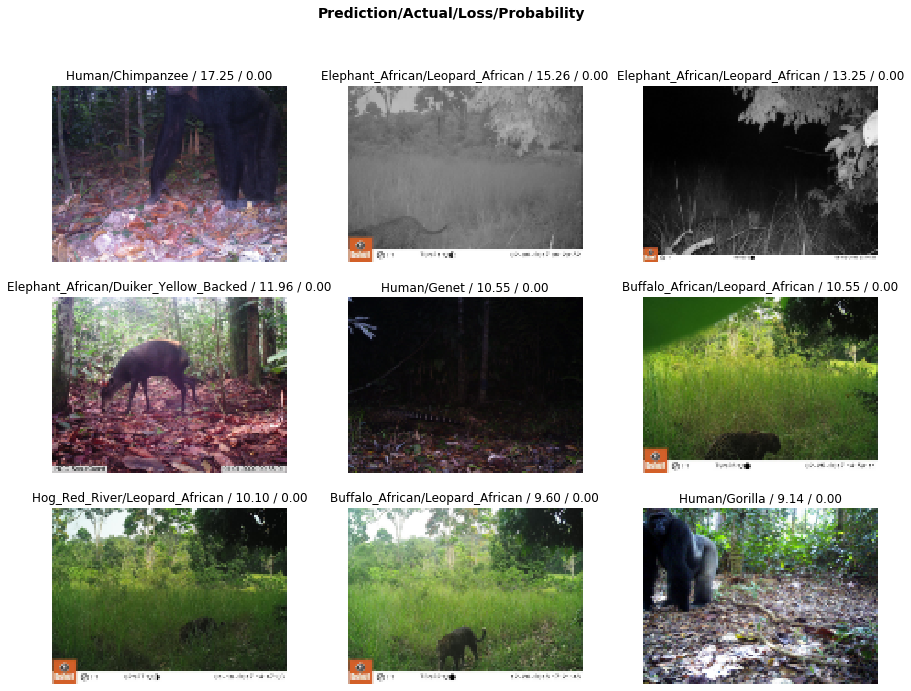

In [30]:
interp.plot_top_losses(9, figsize=(15,11))

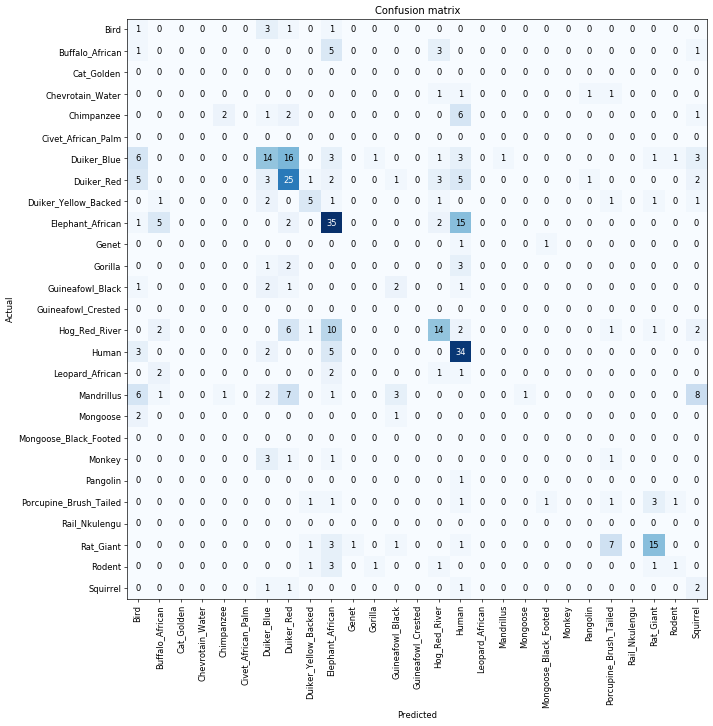

In [31]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)